#### Libraries Imported and Setup

In [1]:
import torch
from torch import nn
from torch import functional as F
from torch import optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('GPU: ', torch.cuda.get_device_name(0))

else:
    device = torch.device("cpu")
    print('No GPU available')

GPU:  NVIDIA GeForce RTX 3090


#### Model Architecture

##### Vision Transformer Model

In [3]:
class Attention(nn.Module):
    '''
    Attention Module used to perform self-attention operation allowing the model to attend
    information from different representation subspaces on an input sequence of embeddings.
    The sequence of operations is as follows :-

    Input -> Query, Key, Value -> ReshapeHeads -> Query.TransposedKey -> Softmax -> Dropout
    -> AttentionScores.Value -> ReshapeHeadsBack -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        _reshape_heads(inp) :- 
        Changes the input sequence embeddings to reduced dimension according to the number
        of attention heads to parallelize attention operation
        (batch_size, seq_len, embed_dim) -> (batch_size * heads, seq_len, reduced_dim)

        _reshape_heads_back(inp) :-
        Changes the reduced dimension due to parallel attention heads back to the original
        embedding size
        (batch_size * heads, seq_len, reduced_dim) -> (batch_size, seq_len, embed_dim)

        forward(inp) :-
        Performs the self-attention operation on the input sequence embedding.
        Returns the output of self-attention as well as atttention scores
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim), (batch_size * heads, seq_len, seq_len)

    Examples:
        >>> attention = Attention(embed_dim, heads, activation, dropout)
        >>> out, weights = attention(inp)
    '''
    def __init__(self, embed_dim, heads=8, activation=None, dropout=0.1):
        super(Attention, self).__init__()
        self.heads = heads
        self.embed_dim = embed_dim
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.softmax = nn.Softmax(dim=-1)
        if activation == 'relu':
            self.activation = nn.ReLU()
        else:
            self.activation = nn.Identity()
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        query = self.activation(self.query(inp))
        key   = self.activation(self.key(inp))
        value = self.activation(self.value(inp))

        # output of _reshape_heads(): (batch_size * heads, seq_len, reduced_dim) | reduced_dim = embed_dim // heads
        query = self._reshape_heads(query)
        key   = self._reshape_heads(key)
        value = self._reshape_heads(value)

        # attention_scores: (batch_size * heads, seq_len, seq_len) | Softmaxed along the last dimension
        attention_scores = self.softmax(torch.matmul(query, key.transpose(1, 2)))

        # out: (batch_size * heads, seq_len, reduced_dim)
        out = torch.matmul(self.dropout(attention_scores), value)
        
        # output of _reshape_heads_back(): (batch_size, seq_len, embed_size)
        out = self._reshape_heads_back(out)

        return out, attention_scores

    def _reshape_heads(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()

        reduced_dim = self.embed_dim // self.heads
        assert reduced_dim * self.heads == self.embed_dim
        out = inp.reshape(batch_size, seq_len, self.heads, reduced_dim)
        out = out.permute(0, 2, 1, 3)
        out = out.reshape(-1, seq_len, reduced_dim)

        # out: (batch_size * heads, seq_len, reduced_dim)
        return out

    def _reshape_heads_back(self, inp):
        # inp: (batch_size * heads, seq_len, reduced_dim) | reduced_dim = embed_dim // heads
        batch_size_mul_heads, seq_len, reduced_dim = inp.size()
        batch_size = batch_size_mul_heads // self.heads

        out = inp.reshape(batch_size, self.heads, seq_len, reduced_dim)
        out = out.permute(0, 2, 1, 3)
        out = out.reshape(batch_size, seq_len, self.embed_dim)

        # out: (batch_size, seq_len, embed_dim)
        return out

In [4]:
# Check if Dropout should be used after second Linear Layer
class FeedForward(nn.Module):
    '''
    FeedForward Network with two sequential linear layers with GELU activation function
    ,applied to the output of self attention operation. The sequence of operations is as
    follows :-
    
    Input -> FC1 -> GELU -> Dropout -> FC2 -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> FF = FeedForward(8, 1)
        >>> out = FF(inp)
    '''
    def __init__(self, embed_dim, forward_expansion=1, dropout=0.1):
        super(FeedForward, self).__init__()
        self.embed_dim = embed_dim
        self.fc1 = nn.Linear(embed_dim, embed_dim * forward_expansion)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim * forward_expansion, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        out = self.dropout(self.activation(self.fc1(inp)))
        # out = self.dropout(self.fc2(out))
        out = self.fc2(out)

        # out: (batch_size, seq_len, embed_dim)
        return out 

In [5]:
class TransformerBlock(nn.Module):
    '''
    Transformer Block combines both the attention module and the feed forward module with layer
    normalization, dropout and residual connections. The sequence of operations is as follows :-
    
    Input -> LayerNorm1 -> Attention -> Residual -> LayerNorm2 -> FeedForward -> Output
      |                                   |  |                                      |
      |-------------Addition--------------|  |---------------Addition---------------|

    Args:
        embed_dim: Dimension size of the hidden embedding
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)
    
    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> TB = TransformerBlock(embed_dim, heads, activation, forward_expansion, dropout)
        >>> out = TB(inp)
    '''
    def __init__(self, embed_dim, heads=8, activation=None, forward_expansion=1, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.embed_dim = embed_dim
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attention = Attention(embed_dim, heads, activation, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.feed_forward = FeedForward(embed_dim, forward_expansion, dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        res = inp
        out = self.norm1(inp)
        out, _ = self.attention(out)
        out = out + res
        
        res = out
        out = self.norm2(out)
        out = self.feed_forward(out)
        out = out + res

        # out: (batch_size, seq_len, embed_dim)
        return out

In [6]:
class Transformer(nn.Module):
    '''
    Transformer combines multiple layers of Transformer Blocks in a sequential manner. The sequence
    of the operations is as follows -

    Input -> TB1 -> TB2 -> .......... -> TBn (n being the number of layers) -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        layers: Number of Transformer Blocks in the Transformer
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)
    
    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> transformer = Transformer(embed_dim, layers, heads, activation, forward_expansion, dropout)
        >>> out = transformer(inp)
    '''
    def __init__(self, embed_dim, layers, heads=8, activation=None, forward_expansion=1, dropout=0.1):
        super(Transformer, self).__init__()
        self.embed_dim = embed_dim
        self.trans_blocks = nn.ModuleList(
            [TransformerBlock(embed_dim, heads, activation, forward_expansion, dropout) for i in range(layers)]
        )

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)

        out = inp
        for block in self.trans_blocks:
            out = block(out)

        # out: (batch_size, seq_len, embed_dim)
        return out

In [7]:
# Not Exactly Same as Paper
class ClassificationHead(nn.Module):
    '''
    Classification Head attached to the first sequence token which is used as the arbitrary 
    classification token and used to optimize the transformer model by applying Cross-Entropy 
    loss. The sequence of operations is as follows :-

    Input -> FC1 -> GELU -> Dropout -> FC2 -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        classes: Number of classification classes in the dataset
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, embed_dim) -> (batch_size, classes)

    Examples:
        >>> CH = ClassificationHead(embed_dim, classes, dropout)
        >>> out = CH(inp)
    '''
    def __init__(self, embed_dim, classes, dropout=0.1):
        super(ClassificationHead, self).__init__()
        self.embed_dim = embed_dim
        self.classes = classes
        self.fc1 = nn.Linear(embed_dim, embed_dim // 2)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim // 2, classes)
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, inp):
        # inp: (batch_size, embed_dim)
        batch_size, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        out = self.dropout(self.activation(self.fc1(inp)))
        # out = self.softmax(self.fc2(out))
        out = self.fc2(out)

        # out: (batch_size, classes) 
        return out

In [8]:
class VisionTransformer(nn.Module):
    '''
    Vision Transformer is the complete end to end model architecture which combines all the above modules
    in a sequential manner. The sequence of the operations is as follows -

    Input -> CreatePatches -> ClassToken, PatchToEmbed , PositionEmbed -> Transformer -> ClassificationHead -> Output
                                   |            | |                |
                                   |---Concat---| |----Addition----|
    
    Args:
        patch_size: Length of square patch size 
        max_len: Max length of learnable positional embedding
        embed_dim: Dimension size of the hidden embedding
        classes: Number of classes in the dataset
        layers: Number of Transformer Blocks in the Transformer
        channels: Number of channels in the input (Default=3)
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)
    
    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        It outputs the classification output as well as the sequence output of the transformer
        (batch_size, channels, width, height) -> (batch_size, classes), (batch_size, seq_len+1, embed_dim)
    
    Examples:
        >>> ViT = VisionTransformer(atch_size, max_len, embed_dim, classes, layers, channels, heads, activation, forward_expansion, dropout)
        >>> class_out, hidden_seq = ViT(inp)
    '''
    def __init__(self, patch_size, max_len, embed_dim, classes, layers, channels=3, heads=8, activation=None, forward_expansion=1, dropout=0.1):
        super(VisionTransformer, self).__init__()
        self.name = 'VisionTransformer'
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.channels = channels
        self.patch_to_embed = nn.Linear(patch_size * patch_size * channels, embed_dim)
        self.position_embed = nn.Parameter(torch.randn((max_len, embed_dim)))
        self.transformer = Transformer(embed_dim, layers, heads, activation, forward_expansion, dropout)
        self.classification_head = ClassificationHead(embed_dim, classes)
        self.class_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

    def forward(self, inp):
        # inp: (batch_size, channels, width, height)
        batch_size, channels, width, height = inp.size()
        assert channels == self.channels

        out = inp.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size).contiguous()
        out = out.view(batch_size, channels, -1, self.patch_size, self.patch_size)
        out = out.permute(0, 2, 3, 4, 1)
        # out: (batch_size, seq_len, patch_size, patch_size, channels) | seq_len would be (width*height)/(patch_size**2)
        batch_size, seq_len, patch_size, _, channels = out.size()
        
        out = out.reshape(batch_size, seq_len, -1)
        out = self.patch_to_embed(out)
        # out: (batch_size, seq_len, embed_dim)

        class_token = self.class_token.expand(batch_size, -1, -1)
        out = torch.cat([class_token, out], dim=1)
        # out: (batch_size, seq_len+1, embed_dim)

        position_embed = self.position_embed[:seq_len+1]
        position_embed = position_embed.unsqueeze(0).expand(batch_size, seq_len+1, self.embed_dim)
        out = out + position_embed
        # out: (batch_size, seq_len+1, embed_dim) | Added Positional Embeddings

        out = self.transformer(out)
        # out: (batch_size, seq_len+1, embed_dim) 
        class_token = out[:, 0]
        # class_token: (batch_size, embed_dim)

        class_out = self.classification_head(class_token)
        # class_out: (batch_size, classes)
        
        return class_out, out

In [9]:
import torch
import torch.nn as nn
from torchvision.models import resnet34

class ResNetFeatures(nn.Module):
    '''
    ResNetFeatures outputs the lower level features from pretrained ResNet34 till the intial 5 layers 
    (conv1, bn1, relu, maxpool, layer1(3 conv layers)) to be used in the hybrid architecture to be 
    able to kickstart the learining faster. The sequence of operations is as follows :-

    Input -> conv1 -> bn1 -> relu -> maxpool -> layer1 -> Output

    Args:
        No arguments required
    
    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, 3, 224, 224) -> (batch_size, 64, 56, 56)
    
    Examples:
        >>> resnet_features = ResNetFeatures()
        >>> out = resnet_features(inp)
    '''
    def __init__(self):
        super(ResNetFeatures, self).__init__()
        layers = list(resnet34(pretrained=True).children())[:5] #all layer expect last layer
        self.feature_extractor = nn.Sequential(*layers)
        
    def forward(self, inp):
        # inp: (batch_size, 3, 224, 224)

        out = self.feature_extractor(inp)

        # out: (batch_size, 64, 56, 56)
        return out

##### ResNet Models

In [10]:
class ResidualBlockSmall(nn.Module):
    '''
    ResidualBlockSmall implements the smaller block of the Residual Networks. It optionally also downsamples
    the input according to the stride to match the output while adding the residual. The sequence of operations
    is as follows :-

    Input -> Conv1 -> BNorm1 -> ReLU -> Conv2 -> BNorm2 -> ReLU -> Output
      |                                                              |
      |-----------------Residual_Downsample (Optional)---------------|

    Args:
        input_channels: Number of input channels
        out_channels: Number of output channels
        residual_downsample: Residual Downsample dependent on if either height, width or channels change
        stride: Stride value for the convolutional layers (Default=1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, input_channels, height, width) -> (batch_size, out_channels, height, width)
    
    Examples:
        >>> RBS = ResidualBlockSmall(input_channels, out_channels, residual_downsample, stride)
        >>> out = RBS(inp)
    '''
    def __init__(self, input_channels, out_channels, residual_downsample=None, stride=1):
        super(ResidualBlockSmall, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bnorm2 = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()
        self.residual_downsample = residual_downsample
    
    def forward(self, inp):
        # inp: (batch_size, input_channels, height, width)

        res = inp
        out = self.activation(self.bnorm1(self.conv1(inp)))
        out = self.activation(self.bnorm2(self.conv2(out)))
        
        if self.residual_downsample is not None:
            res = self.residual_downsample(res)

        out = self.activation(out + res)

        # out: (batch_size, out_channels, height, width) | height, width depending on stride
        return out

In [11]:
class ResNetSmall(nn.Module):
    '''
    ResNetSmall consists of layers of the smaller residual block defined above (ResidualBlockSmall).
    The layers are the residual blocks. The sequence of operations is as follows :-

    Input -> Conv1 -> BNorm1 -> ReLU -> MaxPool -> Layer1 -> Layer2 -> Layer3 -> Layer4 -> AvgPool -> FC

    Args:
        layers: A four value array containing number of conv layers in each residual block
        input_channels: number of input channels
        classes: Number of classes in the dataset
    
    Methods:
        _layer(num_layers (Number of conv layers)
               ,input_channels (Number of input channels)
               ,output_channels (Number of output channels)
               ,stride (Stride value for conv layer)) :-
        Returns the sequential wrapper with all the layers in the residual block constructed according
        to the parameters.

        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, input_channels, height, width) -> (batch_size, classes)

    Examples:
        >>> resnet = ResNetSmall(layers, input_channels, classes)
        >>> out = resnet(inp)
    '''
    def __init__(self, layers, input_channels, classes):
        super(ResNetSmall, self).__init__()
        self.name = 'ResNet'
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bnorm1 = nn.BatchNorm2d(64)
        self.activation = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._layer(layers[0], input_channels=64, output_channels=64, stride=1)
        self.layer2 = self._layer(layers[1], input_channels=64, output_channels=128, stride=2)
        self.layer3 = self._layer(layers[2], input_channels=128, output_channels=256, stride=2)
        self.layer4 = self._layer(layers[3], input_channels=256, output_channels=512, stride=2)

        self.avppool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, classes)

    def forward(self, inp):
        # inp: (batch_size, input_channels, height, width)

        out = self.activation(self.bnorm1(self.conv1(inp)))
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avppool(out)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)

        # out: (batch_size, classes)
        return out

    def _layer(self, num_layers, input_channels, output_channels, stride):
        residual_downsample = None
        layers = []

        if stride != 1:
            residual_downsample = nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(output_channels * 4)
            )
        
        layers.append(ResidualBlockSmall(input_channels, output_channels, residual_downsample, stride))

        for i in range(num_layers - 1):
            layers.append(ResidualBlockSmall(output_channels, output_channels))

        return nn.Sequential(*layers)

In [12]:
class ResidualBlockLarge(nn.Module):
    '''
    ResidualBlockLarge implements the larger block of the Residual Networks. It optionally also downsamples
    the input according to the stride or output channels to match the output while adding the residual. The 
    sequence of operations is as follows :-

    Input -> Conv1 -> BNorm1 -> ReLU -> Conv2 -> BNorm2 -> ReLU -> Conv3 -> BNorm3 -> ReLU -> Output
      |                                                                                          |
      |-----------------------------Residual_Downsample (Optional)-------------------------------|

    Args:
        input_channels: Number of input channels
        out_channels: Number of output channels
        residual_downsample: Residual Downsample dependent on if either height, width or channels change
        stride: Stride value for the convolutional layers (Default=1)
        expansion: Expansion of the input channels during convolutions (Default=4)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, input_channels, height, width) -> (batch_size, out_channels * expansion, height, width)
    
    Examples:
        >>> RBL = ResidualBlockLarge(input_channels, out_channels, residual_downsample, stride, expansion)
        >>> out = RBL(inp)
    '''
    def __init__(self, input_channels, out_channels, residual_downsample=None, stride=1, expansion=4):
        super(ResidualBlockLarge, self).__init__()
        self.expansion = expansion
        self.conv1 = nn.Conv2d(input_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bnorm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bnorm2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * expansion, kernel_size=1, stride=1, padding=0)
        self.bnorm3 = nn.BatchNorm2d(out_channels * expansion)
        self.activation = nn.ReLU()
        self.residual_downsample = residual_downsample
    
    def forward(self, inp):
        # inp: (batch_size, input_channels, height, width)

        res = inp
        out = self.activation(self.bnorm1(self.conv1(inp)))
        out = self.activation(self.bnorm2(self.conv2(out)))
        out = self.activation(self.bnorm3(self.conv3(out)))
        
        if self.residual_downsample is not None:
            res = self.residual_downsample(res)

        out = self.activation(out + res)

        # out: (batch_size, out_channels * expansion, height, width) | height, width depending on stride
        return out

In [13]:
class ResNetLarge(nn.Module):
    '''
    ResNetLarge consists of layers of the larger residual block defined above (ResidualBlockLarger).
    The layers are the residual blocks. The sequence of operations is as follows :-

    Input -> Conv1 -> BNorm1 -> ReLU -> MaxPool -> Layer1 -> Layer2 -> Layer3 -> Layer4 -> AvgPool -> FC

    Args:
        layers: A four value array containing number of conv layers in each residual block
        input_channels: number of input channels
        classes: Number of classes in the dataset
    
    Methods:
        _layer(num_layers (Number of conv layers)
               ,input_channels (Number of input channels)
               ,output_channels (Number of output channels)
               ,stride (Stride value for conv layer)) :-
        Returns the sequential wrapper with all the layers in the residual block constructed according
        to the parameters.

        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, input_channels, height, width) -> (batch_size, classes)

    Examples:
        >>> resnet = ResNetLarge(layers, input_channels, classes)
        >>> out = resnet(inp)
    '''
    def __init__(self, layers, input_channels, classes):
        super(ResNetLarge, self).__init__()
        self.name = 'ResNet'
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bnorm1 = nn.BatchNorm2d(64)
        self.activation = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._layer(layers[0], input_channels=64, output_channels=64, stride=1)
        self.layer2 = self._layer(layers[1], input_channels=256, output_channels=128, stride=2)
        self.layer3 = self._layer(layers[2], input_channels=512, output_channels=256, stride=2)
        self.layer4 = self._layer(layers[3], input_channels=1024, output_channels=512, stride=2)

        self.avppool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, classes)

    def forward(self, inp):
        # inp: (batch_size, input_channels, height, width)

        out = self.activation(self.bnorm1(self.conv1(inp)))
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avppool(out)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)

        # out: (batch_size, classes)
        return out

    def _layer(self, num_layers, input_channels, output_channels, stride):
        residual_downsample = None
        layers = []

        # Checks if there would be potential mismatch in any of height, width or channels between input and output. 
        # 4 is the value of the expansion for large ResNets
        if stride != 1 or input_channels != output_channels * 4:
            residual_downsample = nn.Sequential(
                nn.Conv2d(input_channels, output_channels * 4, kernel_size=1, stride=stride),
                nn.BatchNorm2d(output_channels * 4)
            )
        
        layers.append(ResidualBlockLarge(input_channels, output_channels, residual_downsample, stride))

        for i in range(num_layers - 1):
            layers.append(ResidualBlockLarge(output_channels * 4, output_channels))

        return nn.Sequential(*layers)

In [14]:
def ResNet34(input_channels, classes):
    '''
    Initalization of ResNet34 using the layers as mentioned in the paper and using ResNetSmall module.

    Args:
        input_channels: Number of input channels
        classes: Number of classes in the dataset
    
    Output:
        ResNetSmall Object
    '''
    return ResNetSmall([3, 4, 6, 3], input_channels, classes)

In [15]:
def ResNet50(input_channels, classes):
    '''
    Initalization of ResNet50 using the layers as mentioned in the paper and using ResNetLarge module.
    
    Args:
        input_channels: Number of input channels
        classes: Number of classes in the dataset
    
    Output:
        ResNetLarge Object
    '''
    return ResNetLarge([3, 4, 6, 3], input_channels, classes)

#### Data Loading Functions

In [16]:
def CIFAR100DataLoader(split, batch_size=8, num_workers=2, shuffle=True, size='32', normalize='standard'):
    '''
    A wrapper function that creates a DataLoader for CIFAR100 dataset loaded from torchvision using 
    the parameters supplied and applies the required data augmentations.

    Args:
        split: A string to decide if train or test data to be used (Values: 'train', 'test')
        batch_size: Batch size to used for loading data (Default=8)
        num_workers: Number of parallel workers used to load data (Default=2)
        shuffle: Boolean value to decide if data should be randomized (Default=True)
        size: A string to decide the size of the input images (Default='32') (Values: '32','224')
        normalize: A string to decide the normalization to applied to the input images
                   (Default='standard') (Values: 'standard', 'imagenet')
    
    Output:
        DataLoader Object
    '''
    if normalize == 'imagenet':
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    elif normalize == 'standard':
        mean = [0.5, 0.5, 0.5]
        std =  [0.5, 0.5, 0.5]

    if split == 'train':
        if size == '224':
            train_transform = transforms.Compose([
                transforms.RandomResizedCrop((224,224), scale=(0.8, 1.0)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        elif size == '32':
            train_transform = transforms.Compose([
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(15),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        
        cifar100 = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)
        dataloader = DataLoader(cifar100, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)
    
    elif split == 'test':
        if size == '224':
            test_transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])

        elif size == '32':
            test_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])

        cifar100 = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)
        dataloader = DataLoader(cifar100, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)

    return dataloader

In [17]:
def CIFAR10DataLoader(split, batch_size=8, num_workers=2, shuffle=True, size='32', normalize='standard'):
    '''
    A wrapper function that creates a DataLoader for CIFAR10 dataset loaded from torchvision using 
    the parameters supplied and applies the required data augmentations.

    Args:
        split: A string to decide if train or test data to be used (Values: 'train', 'test')
        batch_size: Batch size to used for loading data (Default=8)
        num_workers: Number of parallel workers used to load data (Default=2)
        shuffle: Boolean value to decide if data should be randomized (Default=True)
        size: A string to decide the size of the input images (Default='32') (Values: '32','224')
        normalize: A string to decide the normalization to applied to the input images
                   (Default='standard') (Values: 'standard', 'imagenet')
    
    Output:
        DataLoader Object
    '''
    if normalize == 'imagenet':
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    elif normalize == 'standard':
        mean = [0.5, 0.5, 0.5]
        std =  [0.5, 0.5, 0.5]

    if split == 'train':
        if size == '224':
            train_transform = transforms.Compose([
                transforms.RandomResizedCrop((224,224), scale=(0.5, 1.0)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        elif size == '32':
            train_transform = transforms.Compose([
                transforms.Resize((48, 48)),
                transforms.RandomCrop(32),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(15),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        
        cifar10 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
        dataloader = DataLoader(cifar10, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)
    
    elif split == 'test':
        if size == '224':
            test_transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        elif size == '32':
            test_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])

        cifar10 = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
        dataloader = DataLoader(cifar10, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)

    return dataloader

#### Training and Evaluation Functions

In [18]:
# Initializations of all the constants used in the training and testing process

lr = 0.003
batch_size = 256
num_workers = 2
shuffle = True
patch_size = 4
image_sz = 32
max_len = 100 # All sequences must be less than 1000 including class token
embed_dim = 512
classes = 10
layers = 12
channels = 3
resnet_features_channels = 64
heads = 16
epochs = 100

In [19]:
def train(model, dataloader, criterion, optimizer, scheduler, resnet_features=None):
    '''
    Function used to train the model over a single epoch and update it according to the
    calculated gradients.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        criterion: Criterion used to calculate loss
        optimizer: Optimizer used update the model
        scheduler: Scheduler used to update the learing rate for faster convergence 
                   (Commented out due to poor results)
        resnet_features: Model to get Resnet Features for the hybrid architecture (Default=None)

    Output:
        running_loss: Training Loss (Float)
        running_accuracy: Training Accuracy (Float)
    '''
    running_loss = 0.0
    running_accuracy = 0.0

    for data, target in tqdm(dataloader):
        data = data.to(device)
        target = target.to(device)

        if model.name == 'VisionTransformer':
            with torch.no_grad():
                if resnet_features != None:
                    data = resnet_features(data)
            output, _ = model(data)
        elif model.name == 'ResNet':
            output = model(data)
        loss = criterion(output, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # scheduler.step()

        acc = (output.argmax(dim=1) == target).float().mean()
        running_accuracy += acc / len(dataloader)
        running_loss += loss.item() / len(dataloader)

    return running_loss, running_accuracy

In [20]:
def evaluation(model, dataloader, criterion, resnet_features=None):
    '''
    Function used to evaluate the model on the test dataset.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        criterion: Criterion used to calculate loss
        resnet_features: Model to get Resnet Features for the hybrid architecture (Default=None)
    
    Output:
        test_loss: Testing Loss (Float)
        test_accuracy: Testing Accuracy (Float)
    '''
    with torch.no_grad():
        test_accuracy = 0.0
        test_loss = 0.0
        for data, target in tqdm(dataloader):
            data = data.to(device)
            target = target.to(device)

            if model.name == 'VisionTransformer':
                if resnet_features != None:
                    data = resnet_features(data)
                output, _ = model(data)
            elif model.name == 'ResNet':
                output = model(data)
            loss = criterion(output, target)

            acc = (output.argmax(dim=1) == target).float().mean()
            test_accuracy += acc / len(dataloader)
            test_loss += loss.item() / len(dataloader)

    return test_loss, test_accuracy

#### Model Initialization

Run either one the following subcells according to the models selected to train and test

##### Model - Vision Transformer

Recommended Values for the following Architecture

- patch_size = 4
- max_len = 100
- embed_dim = 512
- classes = According to Dataset
- layers = 12
- channels = 3
- heads = 16

In [21]:
# Vision Transformer Architecture

model = VisionTransformer(
    patch_size=patch_size,
    max_len=max_len,
    embed_dim=embed_dim,
    classes=classes,
    layers=layers,
    channels=channels,
    heads=heads).to(device)

resnet_features = None

In [24]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

15994634

Recommended Values for the following Architecture

- patch_size = 7
- max_len = 100
- embed_dim = 512
- classes = According to Dataset
- layers = 12
- channels = 64 (Resnet Features Channels)
- heads = 16

In [21]:
# Hybrid Vision Transformer Architecture

model = VisionTransformer(
    patch_size=patch_size,
    max_len=max_len,
    embed_dim=embed_dim,
    classes=classes,
    layers=layers,
    channels=resnet_features_channels,
    heads=heads).to(device)

resnet_features = ResNetFeatures().to(device).eval()

In [22]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

16494346

##### Model - ResNet50 or ResNet34

Recommended Values for the following Architecture

- input_channels = 3
- classes = According to Dataset


In [ ]:
# ResNet34 Architecture

model = ResNet34(
    input_channels=3,
    classes=classes).to(device)

resnet_features = None

Recommended Values for the following Architecture

- input_channels = 3
- classes = According to Dataset


In [ ]:
# ResNet50 Architecture

model = ResNet50(
    input_channels=3,
    classes=classes).to(device)

resnet_features = None

#### Model Training and Evaluation

##### CIFAR10 Dataset

In [25]:
%%time
train_dataloader = CIFAR10DataLoader(split='train', batch_size=batch_size, num_workers=num_workers, shuffle=shuffle, size='32', normalize='standard')
test_dataloader = CIFAR10DataLoader(split='test', batch_size=batch_size, num_workers=num_workers, shuffle=False, size='32', normalize='standard')

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_dataloader), epochs=epochs)

train_accs = []
test_accs = []
for epoch in range(epochs):

    running_loss, running_accuracy = train(model, train_dataloader, criterion, optimizer, scheduler, resnet_features)
    print(f"Epoch : {epoch+1} - acc: {running_accuracy:.4f} - loss : {running_loss:.4f}\n")
    train_accs.append(running_accuracy)

    test_loss, test_accuracy = evaluation(model, test_dataloader, criterion, resnet_features)
    print(f"test acc: {test_accuracy:.4f} - test loss : {test_loss:.4f}\n")
    test_accs.append(test_accuracy)

    if (epoch+1)%5 == 0:
        torch.save({
            'epoch': epoch,
            'model': model,
            'optimizer': optimizer,
            'scheduler': scheduler,
            'train_acc': train_accs,
            'test_acc': test_accs
        }, './data/' + model.name + '_CIFAR10_checkpoint.pt') 

Files already downloaded and verified
Files already downloaded and verified


100%|█████████████████████████████████████████| 196/196 [01:19<00:00,  2.48it/s]


Epoch : 1 - acc: 0.2602 - loss : 1.9828



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.77it/s]


test acc: 0.3400 - test loss : 1.8158



100%|█████████████████████████████████████████| 196/196 [01:19<00:00,  2.48it/s]


Epoch : 2 - acc: 0.3277 - loss : 1.8212



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.75it/s]


test acc: 0.3940 - test loss : 1.6542



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.48it/s]


Epoch : 3 - acc: 0.3715 - loss : 1.7153



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.79it/s]


test acc: 0.4086 - test loss : 1.6549



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.48it/s]


Epoch : 4 - acc: 0.4003 - loss : 1.6482



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.78it/s]


test acc: 0.4449 - test loss : 1.5403



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.48it/s]


Epoch : 6 - acc: 0.4326 - loss : 1.5551



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.84it/s]


test acc: 0.4601 - test loss : 1.4947



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.48it/s]


Epoch : 7 - acc: 0.4502 - loss : 1.5133



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.81it/s]


test acc: 0.4803 - test loss : 1.4453



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.48it/s]


Epoch : 8 - acc: 0.4597 - loss : 1.4881



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.80it/s]


test acc: 0.4727 - test loss : 1.5002



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.48it/s]


Epoch : 9 - acc: 0.4716 - loss : 1.4621



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.08it/s]


test acc: 0.4784 - test loss : 1.4340



100%|█████████████████████████████████████████| 196/196 [01:19<00:00,  2.48it/s]


Epoch : 10 - acc: 0.4802 - loss : 1.4338



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.88it/s]


test acc: 0.5032 - test loss : 1.3860



100%|█████████████████████████████████████████| 196/196 [01:19<00:00,  2.47it/s]


Epoch : 11 - acc: 0.4902 - loss : 1.4090



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.82it/s]


test acc: 0.5088 - test loss : 1.3444



100%|█████████████████████████████████████████| 196/196 [01:19<00:00,  2.48it/s]


Epoch : 12 - acc: 0.4985 - loss : 1.3955



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.83it/s]


test acc: 0.5017 - test loss : 1.3750



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.48it/s]


Epoch : 13 - acc: 0.5074 - loss : 1.3735



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.78it/s]


test acc: 0.5059 - test loss : 1.3629



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.49it/s]


Epoch : 14 - acc: 0.5117 - loss : 1.3615



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.80it/s]


test acc: 0.5074 - test loss : 1.3610



100%|█████████████████████████████████████████| 196/196 [01:19<00:00,  2.48it/s]


Epoch : 15 - acc: 0.5199 - loss : 1.3429



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.82it/s]


test acc: 0.5182 - test loss : 1.3449



100%|█████████████████████████████████████████| 196/196 [01:19<00:00,  2.48it/s]


Epoch : 16 - acc: 0.5256 - loss : 1.3220



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.80it/s]


test acc: 0.5107 - test loss : 1.3977



100%|█████████████████████████████████████████| 196/196 [01:19<00:00,  2.48it/s]


Epoch : 17 - acc: 0.5295 - loss : 1.3114



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.94it/s]


test acc: 0.5193 - test loss : 1.3320



 99%|████████████████████████████████████████▌| 194/196 [01:18<00:00,  2.60it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█████████████████████████████████████████| 196/196 [01:19<00:00,  2.48it/s]


Epoch : 66 - acc: 0.6629 - loss : 0.9529



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.82it/s]


test acc: 0.6051 - test loss : 1.1197



100%|█████████████████████████████████████████| 196/196 [01:19<00:00,  2.48it/s]


Epoch : 67 - acc: 0.6607 - loss : 0.9522



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.82it/s]


test acc: 0.6074 - test loss : 1.1414



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.48it/s]


Epoch : 68 - acc: 0.6644 - loss : 0.9465



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.85it/s]


test acc: 0.6037 - test loss : 1.1503



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.48it/s]


Epoch : 69 - acc: 0.6684 - loss : 0.9357



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.84it/s]


test acc: 0.6025 - test loss : 1.1228



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.48it/s]


Epoch : 70 - acc: 0.6700 - loss : 0.9327



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.80it/s]


test acc: 0.5917 - test loss : 1.1888



100%|█████████████████████████████████████████| 196/196 [01:19<00:00,  2.48it/s]


Epoch : 71 - acc: 0.6691 - loss : 0.9327



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.97it/s]


test acc: 0.6042 - test loss : 1.1362



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.49it/s]


Epoch : 72 - acc: 0.6722 - loss : 0.9258



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.80it/s]


test acc: 0.6022 - test loss : 1.1634



100%|█████████████████████████████████████████| 196/196 [01:19<00:00,  2.47it/s]


Epoch : 73 - acc: 0.6728 - loss : 0.9206



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.77it/s]


test acc: 0.6023 - test loss : 1.1647



100%|█████████████████████████████████████████| 196/196 [01:19<00:00,  2.47it/s]


Epoch : 74 - acc: 0.6758 - loss : 0.9177



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.78it/s]


test acc: 0.6093 - test loss : 1.1336



100%|█████████████████████████████████████████| 196/196 [01:19<00:00,  2.48it/s]


Epoch : 75 - acc: 0.6780 - loss : 0.9086



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.80it/s]


test acc: 0.6085 - test loss : 1.1481



100%|█████████████████████████████████████████| 196/196 [01:19<00:00,  2.48it/s]


Epoch : 76 - acc: 0.6786 - loss : 0.9074



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.79it/s]


test acc: 0.6142 - test loss : 1.1455



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.48it/s]


Epoch : 77 - acc: 0.6798 - loss : 0.9032



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.78it/s]


test acc: 0.5982 - test loss : 1.1730



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.48it/s]


Epoch : 78 - acc: 0.6845 - loss : 0.8980



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.79it/s]


test acc: 0.6146 - test loss : 1.1493



100%|█████████████████████████████████████████| 196/196 [01:19<00:00,  2.48it/s]


Epoch : 79 - acc: 0.6838 - loss : 0.8957



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.85it/s]


test acc: 0.6021 - test loss : 1.1737



100%|█████████████████████████████████████████| 196/196 [01:19<00:00,  2.48it/s]


Epoch : 80 - acc: 0.6863 - loss : 0.8877



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.98it/s]


test acc: 0.6012 - test loss : 1.1744



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.48it/s]


Epoch : 81 - acc: 0.6883 - loss : 0.8837



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.75it/s]


test acc: 0.6022 - test loss : 1.1994



100%|█████████████████████████████████████████| 196/196 [01:19<00:00,  2.47it/s]


Epoch : 82 - acc: 0.6863 - loss : 0.8838



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.81it/s]


test acc: 0.6145 - test loss : 1.1355



100%|█████████████████████████████████████████| 196/196 [01:19<00:00,  2.48it/s]


Epoch : 83 - acc: 0.6895 - loss : 0.8746



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.83it/s]


test acc: 0.6081 - test loss : 1.1497



100%|█████████████████████████████████████████| 196/196 [01:19<00:00,  2.48it/s]


Epoch : 84 - acc: 0.6865 - loss : 0.8820



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.83it/s]


test acc: 0.5992 - test loss : 1.1700



100%|█████████████████████████████████████████| 196/196 [01:19<00:00,  2.48it/s]


Epoch : 85 - acc: 0.6922 - loss : 0.8681



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.80it/s]


test acc: 0.6073 - test loss : 1.1596



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.48it/s]


Epoch : 86 - acc: 0.6923 - loss : 0.8637



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.77it/s]


test acc: 0.6096 - test loss : 1.1270



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.48it/s]


Epoch : 87 - acc: 0.6941 - loss : 0.8654



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.85it/s]


test acc: 0.5928 - test loss : 1.2054



100%|█████████████████████████████████████████| 196/196 [01:19<00:00,  2.48it/s]


Epoch : 88 - acc: 0.6950 - loss : 0.8570



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.79it/s]


test acc: 0.6070 - test loss : 1.1647



100%|█████████████████████████████████████████| 196/196 [01:19<00:00,  2.48it/s]


Epoch : 89 - acc: 0.7003 - loss : 0.8476



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.02it/s]


test acc: 0.6054 - test loss : 1.1836



 98%|████████████████████████████████████████▏| 192/196 [01:17<00:01,  2.49it/s]


KeyboardInterrupt: 

In [26]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

15994634

##### CIFAR10 Dataset PRETRAINED

In [23]:
train_dataloader = CIFAR10DataLoader(split='train', batch_size=batch_size, num_workers=num_workers, shuffle=shuffle, size='32', normalize='standard')
test_dataloader = CIFAR10DataLoader(split='test', batch_size=batch_size, num_workers=num_workers, shuffle=False, size='32', normalize='standard')

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_dataloader), epochs=epochs)

train_accs = []
test_accs = []
for epoch in range(epochs):

    running_loss, running_accuracy = train(model, train_dataloader, criterion, optimizer, scheduler, resnet_features)
    print(f"Epoch : {epoch+1} - acc: {running_accuracy:.4f} - loss : {running_loss:.4f}\n")
    train_accs.append(running_accuracy)

    test_loss, test_accuracy = evaluation(model, test_dataloader, criterion, resnet_features)
    print(f"test acc: {test_accuracy:.4f} - test loss : {test_loss:.4f}\n")
    test_accs.append(test_accuracy)

    if (epoch+1)%5 == 0:
        torch.save({
            'epoch': epoch,
            'model': model,
            'optimizer': optimizer,
            'scheduler': scheduler,
            'train_acc': train_accs,
            'test_acc': test_accs
        }, './data/' + model.name + '_CIFAR10_checkpoint.pt') 

Files already downloaded and verified
Files already downloaded and verified


100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 16.37it/s]


Epoch : 1 - acc: 0.2466 - loss : 1.9676



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 43.88it/s]


test acc: 0.3371 - test loss : 1.7537



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 16.38it/s]


Epoch : 2 - acc: 0.3896 - loss : 1.6439



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 42.32it/s]


test acc: 0.4232 - test loss : 1.6434



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 16.39it/s]


Epoch : 3 - acc: 0.4321 - loss : 1.5470



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 41.95it/s]


test acc: 0.3986 - test loss : 1.8473



100%|█████████████████████████████████████████| 196/196 [00:12<00:00, 16.32it/s]


Epoch : 4 - acc: 0.4678 - loss : 1.4661



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 45.74it/s]


test acc: 0.4452 - test loss : 1.6893



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 16.58it/s]


Epoch : 5 - acc: 0.4824 - loss : 1.4284



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 41.94it/s]


test acc: 0.4334 - test loss : 1.8516



100%|█████████████████████████████████████████| 196/196 [00:12<00:00, 16.31it/s]


Epoch : 6 - acc: 0.5009 - loss : 1.3946



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 44.05it/s]


test acc: 0.4574 - test loss : 1.7170



100%|█████████████████████████████████████████| 196/196 [00:12<00:00, 16.26it/s]


Epoch : 7 - acc: 0.5164 - loss : 1.3479



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 43.35it/s]


test acc: 0.5035 - test loss : 1.5188



100%|█████████████████████████████████████████| 196/196 [00:12<00:00, 16.25it/s]


Epoch : 8 - acc: 0.5255 - loss : 1.3250



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 42.70it/s]


test acc: 0.5005 - test loss : 1.5026



100%|█████████████████████████████████████████| 196/196 [00:12<00:00, 16.27it/s]


Epoch : 9 - acc: 0.5366 - loss : 1.2900



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 41.42it/s]


test acc: 0.4804 - test loss : 1.6741



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 16.55it/s]


Epoch : 10 - acc: 0.5496 - loss : 1.2639



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 44.92it/s]


test acc: 0.4789 - test loss : 1.6763



100%|█████████████████████████████████████████| 196/196 [00:12<00:00, 16.13it/s]


Epoch : 11 - acc: 0.5520 - loss : 1.2484



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 47.75it/s]


test acc: 0.5121 - test loss : 1.5390



100%|█████████████████████████████████████████| 196/196 [00:12<00:00, 16.22it/s]


Epoch : 12 - acc: 0.5652 - loss : 1.2189



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 45.08it/s]


test acc: 0.5163 - test loss : 1.5542



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 16.59it/s]


Epoch : 13 - acc: 0.5723 - loss : 1.2029



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 43.63it/s]


test acc: 0.4744 - test loss : 1.7323



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 16.49it/s]


Epoch : 14 - acc: 0.5771 - loss : 1.1872



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 42.98it/s]


test acc: 0.5277 - test loss : 1.4573



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 16.44it/s]


Epoch : 15 - acc: 0.5846 - loss : 1.1673



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 42.51it/s]


test acc: 0.5407 - test loss : 1.4578



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 16.50it/s]


Epoch : 16 - acc: 0.5938 - loss : 1.1445



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 42.17it/s]


test acc: 0.5354 - test loss : 1.4871



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 16.47it/s]


Epoch : 17 - acc: 0.5942 - loss : 1.1392



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 45.68it/s]


test acc: 0.5195 - test loss : 1.5110



100%|█████████████████████████████████████████| 196/196 [00:12<00:00, 16.19it/s]


Epoch : 18 - acc: 0.6042 - loss : 1.1188



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 45.27it/s]


test acc: 0.5264 - test loss : 1.5301



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 16.40it/s]


Epoch : 19 - acc: 0.6102 - loss : 1.1015



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 42.00it/s]


test acc: 0.5338 - test loss : 1.5161



100%|█████████████████████████████████████████| 196/196 [00:12<00:00, 16.24it/s]


Epoch : 20 - acc: 0.6134 - loss : 1.0877



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 42.38it/s]


test acc: 0.5253 - test loss : 1.5194



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 16.39it/s]


Epoch : 21 - acc: 0.6148 - loss : 1.0895



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 42.43it/s]


test acc: 0.5207 - test loss : 1.5442



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 16.46it/s]


Epoch : 22 - acc: 0.6247 - loss : 1.0668



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 44.50it/s]


test acc: 0.5338 - test loss : 1.5415



100%|█████████████████████████████████████████| 196/196 [00:12<00:00, 16.30it/s]


Epoch : 23 - acc: 0.6243 - loss : 1.0647



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 44.43it/s]


test acc: 0.5510 - test loss : 1.4626



100%|█████████████████████████████████████████| 196/196 [00:12<00:00, 16.18it/s]


Epoch : 24 - acc: 0.6271 - loss : 1.0604



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 47.59it/s]


test acc: 0.5577 - test loss : 1.4491



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 16.44it/s]


Epoch : 25 - acc: 0.6344 - loss : 1.0354



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 46.70it/s]


test acc: 0.5513 - test loss : 1.4198



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 16.36it/s]


Epoch : 26 - acc: 0.6366 - loss : 1.0312



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 43.95it/s]


test acc: 0.5533 - test loss : 1.4262



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 16.34it/s]


Epoch : 27 - acc: 0.6391 - loss : 1.0237



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 41.59it/s]


test acc: 0.5668 - test loss : 1.3752



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 16.49it/s]


Epoch : 28 - acc: 0.6421 - loss : 1.0139



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 43.33it/s]


test acc: 0.5562 - test loss : 1.4157



100%|█████████████████████████████████████████| 196/196 [00:12<00:00, 16.24it/s]


Epoch : 29 - acc: 0.6466 - loss : 1.0022



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 42.46it/s]


test acc: 0.5761 - test loss : 1.3712



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 16.41it/s]


Epoch : 30 - acc: 0.6468 - loss : 0.9977



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 43.02it/s]


test acc: 0.5793 - test loss : 1.3494



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 16.36it/s]


Epoch : 31 - acc: 0.6521 - loss : 0.9847



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 43.77it/s]


test acc: 0.5885 - test loss : 1.2772



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 16.46it/s]


Epoch : 32 - acc: 0.6562 - loss : 0.9770



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 45.51it/s]


test acc: 0.5799 - test loss : 1.3611



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 16.41it/s]


Epoch : 33 - acc: 0.6627 - loss : 0.9624



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 43.80it/s]


test acc: 0.5754 - test loss : 1.3959



100%|█████████████████████████████████████████| 196/196 [00:12<00:00, 16.31it/s]


Epoch : 34 - acc: 0.6618 - loss : 0.9591



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 43.43it/s]


test acc: 0.5624 - test loss : 1.3897



100%|█████████████████████████████████████████| 196/196 [00:12<00:00, 16.27it/s]


Epoch : 35 - acc: 0.6635 - loss : 0.9554



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 44.36it/s]


test acc: 0.5943 - test loss : 1.2764



100%|█████████████████████████████████████████| 196/196 [00:12<00:00, 16.30it/s]


Epoch : 36 - acc: 0.6646 - loss : 0.9484



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 44.03it/s]


test acc: 0.5904 - test loss : 1.3031



100%|█████████████████████████████████████████| 196/196 [00:12<00:00, 16.27it/s]


Epoch : 37 - acc: 0.6653 - loss : 0.9472



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 47.18it/s]


test acc: 0.5736 - test loss : 1.3654



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 16.50it/s]


Epoch : 38 - acc: 0.6732 - loss : 0.9260



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.05it/s]


test acc: 0.5596 - test loss : 1.4398



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 16.33it/s]


Epoch : 39 - acc: 0.6735 - loss : 0.9282



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 42.89it/s]


test acc: 0.5752 - test loss : 1.3816



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 16.40it/s]


Epoch : 40 - acc: 0.6764 - loss : 0.9250



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 42.58it/s]


test acc: 0.5983 - test loss : 1.2741



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 16.34it/s]


Epoch : 41 - acc: 0.6791 - loss : 0.9074



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 44.02it/s]


test acc: 0.5595 - test loss : 1.5286



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 16.39it/s]


Epoch : 42 - acc: 0.6779 - loss : 0.9149



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 44.30it/s]


test acc: 0.5820 - test loss : 1.3577



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 16.47it/s]


Epoch : 43 - acc: 0.6822 - loss : 0.9031



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 43.17it/s]


test acc: 0.5697 - test loss : 1.4031



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 16.40it/s]


Epoch : 44 - acc: 0.6824 - loss : 0.9016



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 43.02it/s]


test acc: 0.5592 - test loss : 1.4049



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 16.39it/s]


Epoch : 45 - acc: 0.6857 - loss : 0.8977



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 42.82it/s]


test acc: 0.5828 - test loss : 1.3456



100%|█████████████████████████████████████████| 196/196 [00:12<00:00, 16.13it/s]


Epoch : 46 - acc: 0.6887 - loss : 0.8887



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 45.05it/s]


test acc: 0.5974 - test loss : 1.2766



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 16.46it/s]


Epoch : 47 - acc: 0.6857 - loss : 0.8862



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 44.05it/s]


test acc: 0.5967 - test loss : 1.2626



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 16.55it/s]


Epoch : 48 - acc: 0.6935 - loss : 0.8714



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 42.98it/s]


test acc: 0.6231 - test loss : 1.1560



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 16.45it/s]


Epoch : 49 - acc: 0.6944 - loss : 0.8681



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 42.74it/s]


test acc: 0.6174 - test loss : 1.2089



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 16.39it/s]


Epoch : 50 - acc: 0.6975 - loss : 0.8600



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 46.02it/s]


test acc: 0.6023 - test loss : 1.2962



100%|█████████████████████████████████████████| 196/196 [00:12<00:00, 16.31it/s]


Epoch : 51 - acc: 0.6984 - loss : 0.8533



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 47.73it/s]


test acc: 0.6107 - test loss : 1.2707



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 16.37it/s]


Epoch : 52 - acc: 0.7007 - loss : 0.8470



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 41.59it/s]


test acc: 0.6142 - test loss : 1.2448



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 16.40it/s]


Epoch : 53 - acc: 0.7021 - loss : 0.8513



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 44.54it/s]


test acc: 0.5927 - test loss : 1.3402



100%|█████████████████████████████████████████| 196/196 [00:12<00:00, 16.28it/s]


Epoch : 54 - acc: 0.7024 - loss : 0.8419



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 43.61it/s]


test acc: 0.6086 - test loss : 1.2216



100%|█████████████████████████████████████████| 196/196 [00:12<00:00, 16.19it/s]


Epoch : 55 - acc: 0.7094 - loss : 0.8315



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 43.11it/s]


test acc: 0.6125 - test loss : 1.2094



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 16.60it/s]


Epoch : 56 - acc: 0.7085 - loss : 0.8288



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 44.61it/s]


test acc: 0.6099 - test loss : 1.2468



100%|█████████████████████████████████████████| 196/196 [00:12<00:00, 16.23it/s]


Epoch : 57 - acc: 0.7077 - loss : 0.8243



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 43.85it/s]


test acc: 0.6256 - test loss : 1.1992



100%|█████████████████████████████████████████| 196/196 [00:12<00:00, 16.32it/s]


Epoch : 58 - acc: 0.7089 - loss : 0.8265



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 42.87it/s]


test acc: 0.6059 - test loss : 1.2401



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 16.39it/s]


Epoch : 59 - acc: 0.7128 - loss : 0.8156



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 43.21it/s]


test acc: 0.6016 - test loss : 1.3459



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 16.44it/s]


Epoch : 60 - acc: 0.7189 - loss : 0.8070



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 43.30it/s]


test acc: 0.6022 - test loss : 1.2864



100%|█████████████████████████████████████████| 196/196 [00:12<00:00, 16.30it/s]


Epoch : 61 - acc: 0.7175 - loss : 0.8055



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 42.07it/s]


test acc: 0.6337 - test loss : 1.1513



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 16.45it/s]


Epoch : 62 - acc: 0.7170 - loss : 0.7990



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 41.13it/s]


test acc: 0.6106 - test loss : 1.2186



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.31it/s]


Epoch : 63 - acc: 0.7168 - loss : 0.7988



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.82it/s]


test acc: 0.6302 - test loss : 1.1727



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.16it/s]


Epoch : 64 - acc: 0.7229 - loss : 0.7877



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 47.67it/s]


test acc: 0.6300 - test loss : 1.1704



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.26it/s]


Epoch : 65 - acc: 0.7245 - loss : 0.7823



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 47.41it/s]


test acc: 0.6366 - test loss : 1.1525



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.13it/s]


Epoch : 66 - acc: 0.7218 - loss : 0.7884



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 47.78it/s]


test acc: 0.6141 - test loss : 1.2073



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.10it/s]


Epoch : 67 - acc: 0.7272 - loss : 0.7723



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.88it/s]


test acc: 0.6278 - test loss : 1.1812



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.30it/s]


Epoch : 68 - acc: 0.7262 - loss : 0.7786



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 47.66it/s]


test acc: 0.6153 - test loss : 1.2231



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.21it/s]


Epoch : 69 - acc: 0.7272 - loss : 0.7774



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 50.23it/s]


test acc: 0.6181 - test loss : 1.2256



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.01it/s]


Epoch : 70 - acc: 0.7321 - loss : 0.7702



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.30it/s]


test acc: 0.6047 - test loss : 1.2974



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.58it/s]


Epoch : 71 - acc: 0.7304 - loss : 0.7658



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.26it/s]


test acc: 0.5995 - test loss : 1.3237



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.13it/s]


Epoch : 72 - acc: 0.7316 - loss : 0.7603



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.78it/s]


test acc: 0.6078 - test loss : 1.2824



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.32it/s]


Epoch : 73 - acc: 0.7306 - loss : 0.7592



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.82it/s]


test acc: 0.6273 - test loss : 1.1858



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.05it/s]


Epoch : 74 - acc: 0.7340 - loss : 0.7540



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.52it/s]


test acc: 0.6182 - test loss : 1.2156



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.25it/s]


Epoch : 75 - acc: 0.7345 - loss : 0.7499



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 50.26it/s]


test acc: 0.6294 - test loss : 1.1584



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.21it/s]


Epoch : 76 - acc: 0.7380 - loss : 0.7444



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 50.42it/s]


test acc: 0.6240 - test loss : 1.1812



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.21it/s]


Epoch : 77 - acc: 0.7379 - loss : 0.7430



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.61it/s]


test acc: 0.6094 - test loss : 1.2511



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.11it/s]


Epoch : 78 - acc: 0.7376 - loss : 0.7392



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.89it/s]


test acc: 0.6291 - test loss : 1.2159



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.14it/s]


Epoch : 79 - acc: 0.7422 - loss : 0.7367



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 50.84it/s]


test acc: 0.6282 - test loss : 1.2034



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.12it/s]


Epoch : 80 - acc: 0.7404 - loss : 0.7367



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 50.06it/s]


test acc: 0.6089 - test loss : 1.2640



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.35it/s]


Epoch : 81 - acc: 0.7429 - loss : 0.7254



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 50.74it/s]


test acc: 0.6315 - test loss : 1.1922



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.09it/s]


Epoch : 82 - acc: 0.7454 - loss : 0.7220



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.85it/s]


test acc: 0.6242 - test loss : 1.1953



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 18.95it/s]


Epoch : 83 - acc: 0.7469 - loss : 0.7215



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 50.33it/s]


test acc: 0.6242 - test loss : 1.2088



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 18.94it/s]


Epoch : 84 - acc: 0.7460 - loss : 0.7174



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 50.32it/s]


test acc: 0.6218 - test loss : 1.2130



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.28it/s]


Epoch : 85 - acc: 0.7470 - loss : 0.7186



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.46it/s]


test acc: 0.6246 - test loss : 1.2671



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.08it/s]


Epoch : 86 - acc: 0.7500 - loss : 0.7112



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.96it/s]


test acc: 0.6275 - test loss : 1.1994



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.06it/s]


Epoch : 87 - acc: 0.7494 - loss : 0.7068



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 47.25it/s]


test acc: 0.6146 - test loss : 1.2685



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.02it/s]


Epoch : 88 - acc: 0.7496 - loss : 0.7053



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.52it/s]


test acc: 0.6250 - test loss : 1.2165



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.07it/s]


Epoch : 89 - acc: 0.7526 - loss : 0.7012



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.13it/s]


test acc: 0.6354 - test loss : 1.2242



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.19it/s]


Epoch : 90 - acc: 0.7520 - loss : 0.7037



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.53it/s]


test acc: 0.6311 - test loss : 1.2171



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.29it/s]


Epoch : 91 - acc: 0.7530 - loss : 0.6973



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 50.18it/s]


test acc: 0.6227 - test loss : 1.2768



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.15it/s]


Epoch : 92 - acc: 0.7524 - loss : 0.6986



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.90it/s]


test acc: 0.6354 - test loss : 1.1426



 90%|█████████████████████████████████████    | 177/196 [00:09<00:00, 19.12it/s]


KeyboardInterrupt: 

In [26]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

15994634

##### CIFAR100 Dataset

In [23]:
%%time
train_dataloader = CIFAR100DataLoader(split='train', batch_size=batch_size, num_workers=num_workers, shuffle=shuffle, size='32', normalize='standard')
test_dataloader = CIFAR100DataLoader(split='test', batch_size=batch_size, num_workers=num_workers, shuffle=False, size='32', normalize='standard')

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_dataloader), epochs=epochs)

train_accs = []
test_accs = []
for epoch in range(epochs):

    running_loss, running_accuracy = train(model, train_dataloader, criterion, optimizer, scheduler, resnet_features)
    print(f"Epoch : {epoch+1} - acc: {running_accuracy:.4f} - loss : {running_loss:.4f}\n")
    train_accs.append(running_accuracy)

    test_loss, test_accuracy = evaluation(model, test_dataloader, criterion, resnet_features)
    print(f"test acc: {test_accuracy:.4f} - test loss : {test_loss:.4f}\n")
    test_accs.append(test_accuracy)

    if (epoch+1)%5 == 0:
        torch.save({
            'epoch': epoch,
            'model': model,
            'optimizer': optimizer,
            'scheduler': scheduler,
            'train_acc': train_accs,
            'test_acc': test_accs
        }, './checkpoints/' + model.name + '_CIFAR100_checkpoint.pt') 

Files already downloaded and verified
Files already downloaded and verified


100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.49it/s]


Epoch : 2 - acc: 0.1064 - loss : 3.8650



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.75it/s]


test acc: 0.1376 - test loss : 3.7202



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.48it/s]


Epoch : 3 - acc: 0.1392 - loss : 3.6638



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.85it/s]


test acc: 0.1636 - test loss : 3.5358



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.48it/s]


Epoch : 4 - acc: 0.1648 - loss : 3.5031



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.84it/s]


test acc: 0.1889 - test loss : 3.3962



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.49it/s]


Epoch : 5 - acc: 0.1870 - loss : 3.3834



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.79it/s]


test acc: 0.2085 - test loss : 3.2825



100%|█████████████████████████████████████████| 196/196 [01:19<00:00,  2.48it/s]


Epoch : 6 - acc: 0.2057 - loss : 3.2818



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.78it/s]


test acc: 0.2286 - test loss : 3.1973



100%|█████████████████████████████████████████| 196/196 [01:19<00:00,  2.48it/s]


Epoch : 7 - acc: 0.2183 - loss : 3.1952



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.82it/s]


test acc: 0.2306 - test loss : 3.1426



100%|█████████████████████████████████████████| 196/196 [01:19<00:00,  2.48it/s]


Epoch : 8 - acc: 0.2338 - loss : 3.1244



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.93it/s]


test acc: 0.2497 - test loss : 3.0823



100%|█████████████████████████████████████████| 196/196 [01:19<00:00,  2.48it/s]


Epoch : 9 - acc: 0.2434 - loss : 3.0562



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.18it/s]


test acc: 0.2620 - test loss : 3.0227



100%|█████████████████████████████████████████| 196/196 [01:19<00:00,  2.48it/s]


Epoch : 10 - acc: 0.2546 - loss : 2.9951



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.85it/s]


test acc: 0.2742 - test loss : 2.9528



100%|█████████████████████████████████████████| 196/196 [01:19<00:00,  2.47it/s]


Epoch : 11 - acc: 0.2654 - loss : 2.9412



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.76it/s]


test acc: 0.2794 - test loss : 2.9239



100%|█████████████████████████████████████████| 196/196 [01:19<00:00,  2.48it/s]


Epoch : 12 - acc: 0.2764 - loss : 2.8941



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.79it/s]


test acc: 0.2822 - test loss : 2.9016



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.48it/s]


Epoch : 13 - acc: 0.2843 - loss : 2.8358



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.75it/s]


test acc: 0.2936 - test loss : 2.8636



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.49it/s]


Epoch : 14 - acc: 0.2947 - loss : 2.7976



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.77it/s]


test acc: 0.2990 - test loss : 2.8065



  4%|█▌                                         | 7/196 [00:02<01:16,  2.49it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█████████████████████████████████████████| 196/196 [01:19<00:00,  2.48it/s]


Epoch : 49 - acc: 0.5369 - loss : 1.6625



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.84it/s]


test acc: 0.3972 - test loss : 2.4653



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.48it/s]


Epoch : 50 - acc: 0.5410 - loss : 1.6395



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.77it/s]


test acc: 0.4018 - test loss : 2.4784



100%|█████████████████████████████████████████| 196/196 [01:19<00:00,  2.48it/s]


Epoch : 51 - acc: 0.5506 - loss : 1.5994



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.78it/s]


test acc: 0.4009 - test loss : 2.4610



100%|█████████████████████████████████████████| 196/196 [01:19<00:00,  2.48it/s]


Epoch : 52 - acc: 0.5581 - loss : 1.5765



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.84it/s]


test acc: 0.3959 - test loss : 2.5089



100%|█████████████████████████████████████████| 196/196 [01:19<00:00,  2.48it/s]


Epoch : 53 - acc: 0.5647 - loss : 1.5423



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.94it/s]


test acc: 0.4034 - test loss : 2.4962



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.48it/s]


Epoch : 54 - acc: 0.5747 - loss : 1.5065



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.13it/s]


test acc: 0.4037 - test loss : 2.5152



100%|█████████████████████████████████████████| 196/196 [01:19<00:00,  2.47it/s]


Epoch : 55 - acc: 0.5785 - loss : 1.4870



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.76it/s]


test acc: 0.4007 - test loss : 2.5019



100%|█████████████████████████████████████████| 196/196 [01:19<00:00,  2.48it/s]


Epoch : 56 - acc: 0.5857 - loss : 1.4536



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.74it/s]


test acc: 0.4036 - test loss : 2.5180



100%|█████████████████████████████████████████| 196/196 [01:19<00:00,  2.48it/s]


Epoch : 57 - acc: 0.5985 - loss : 1.4155



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.78it/s]


test acc: 0.4071 - test loss : 2.5478



100%|█████████████████████████████████████████| 196/196 [01:19<00:00,  2.48it/s]


Epoch : 58 - acc: 0.6044 - loss : 1.3868



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.80it/s]


test acc: 0.4061 - test loss : 2.5473



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.49it/s]


Epoch : 59 - acc: 0.6117 - loss : 1.3552



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.83it/s]


test acc: 0.4093 - test loss : 2.5304



100%|█████████████████████████████████████████| 196/196 [01:19<00:00,  2.48it/s]


Epoch : 60 - acc: 0.6187 - loss : 1.3196



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.84it/s]


test acc: 0.4023 - test loss : 2.5614



 74%|██████████████████████████████▌          | 146/196 [00:58<00:19,  2.50it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█████████████████████████████████████████| 196/196 [01:19<00:00,  2.47it/s]


Epoch : 73 - acc: 0.7214 - loss : 0.9143



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.83it/s]


test acc: 0.4090 - test loss : 2.8004



100%|█████████████████████████████████████████| 196/196 [01:19<00:00,  2.48it/s]


Epoch : 74 - acc: 0.7363 - loss : 0.8770



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.84it/s]


test acc: 0.4135 - test loss : 2.7473



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.48it/s]


Epoch : 75 - acc: 0.7399 - loss : 0.8547



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.79it/s]


test acc: 0.4093 - test loss : 2.8276



100%|█████████████████████████████████████████| 196/196 [01:19<00:00,  2.47it/s]


Epoch : 76 - acc: 0.7484 - loss : 0.8262



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.83it/s]


test acc: 0.4129 - test loss : 2.8343



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.48it/s]


Epoch : 77 - acc: 0.7552 - loss : 0.7994



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.74it/s]


test acc: 0.4078 - test loss : 2.8359



100%|█████████████████████████████████████████| 196/196 [01:19<00:00,  2.47it/s]


Epoch : 78 - acc: 0.7640 - loss : 0.7719



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.75it/s]


test acc: 0.4118 - test loss : 2.8595



100%|█████████████████████████████████████████| 196/196 [01:19<00:00,  2.47it/s]


Epoch : 79 - acc: 0.7701 - loss : 0.7456



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.77it/s]


test acc: 0.4121 - test loss : 2.9053



100%|█████████████████████████████████████████| 196/196 [01:19<00:00,  2.48it/s]


Epoch : 80 - acc: 0.7749 - loss : 0.7265



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.96it/s]


test acc: 0.4110 - test loss : 2.9130



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.49it/s]


Epoch : 81 - acc: 0.7883 - loss : 0.6864



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.81it/s]


test acc: 0.4147 - test loss : 2.9646



100%|█████████████████████████████████████████| 196/196 [01:19<00:00,  2.48it/s]


Epoch : 82 - acc: 0.7954 - loss : 0.6632



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.84it/s]


test acc: 0.4171 - test loss : 3.0000



100%|█████████████████████████████████████████| 196/196 [01:19<00:00,  2.48it/s]


Epoch : 83 - acc: 0.7957 - loss : 0.6500



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.82it/s]


test acc: 0.4142 - test loss : 3.0046



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.48it/s]


Epoch : 84 - acc: 0.8032 - loss : 0.6290



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.83it/s]


test acc: 0.4161 - test loss : 3.0129



100%|█████████████████████████████████████████| 196/196 [01:19<00:00,  2.47it/s]


Epoch : 85 - acc: 0.8115 - loss : 0.5985



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.85it/s]


test acc: 0.4166 - test loss : 3.0475



100%|█████████████████████████████████████████| 196/196 [01:19<00:00,  2.48it/s]


Epoch : 86 - acc: 0.8196 - loss : 0.5752



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.81it/s]


test acc: 0.4160 - test loss : 3.0501



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.48it/s]


Epoch : 87 - acc: 0.8242 - loss : 0.5625



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.73it/s]


test acc: 0.4122 - test loss : 3.1118



100%|█████████████████████████████████████████| 196/196 [01:19<00:00,  2.48it/s]


Epoch : 88 - acc: 0.8282 - loss : 0.5423



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.84it/s]


test acc: 0.4117 - test loss : 3.0868



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.48it/s]


Epoch : 89 - acc: 0.8326 - loss : 0.5328



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  6.95it/s]


test acc: 0.4125 - test loss : 3.1187



100%|█████████████████████████████████████████| 196/196 [01:18<00:00,  2.49it/s]


Epoch : 90 - acc: 0.8425 - loss : 0.4984



 45%|███████████████████▎                       | 18/40 [00:01<00:02, 10.08it/s]


KeyboardInterrupt: 

In [24]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

16017764

##### Saving accuracy

In [30]:
max(train_accs)

0.7003224492073059

In [31]:
max(test_accs)

0.614550769329071

In [27]:
import csv

dataset = 'cifar10'
path = './results/'
model_name = 'original-time'

with open(path+'train_'+dataset+'_'+model_name+'.csv', 'w', newline='\n') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     for point in train_accs:
        wr.writerow([point])
        
        
with open(path+'test_'+dataset+'_'+model_name+'.csv', 'w', newline='\n') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     for point in test_accs:
        wr.writerow([point])

##### Plotting Results

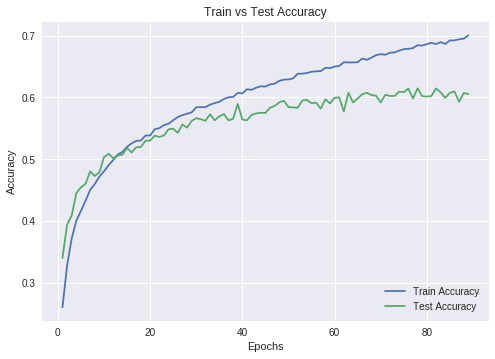

In [29]:
#CIFAR10
# train_accs = [acc.cpu().item() for acc in train_accs]
# test_accs = [acc.cpu().item() for acc in test_accs]
# print(train_accs)
# print(test_accs)
plt.style.use('seaborn')
plt.plot(range(1, 90), train_accs, label='Train Accuracy')
plt.plot(range(1, 90), test_accs, label='Test Accuracy')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.title("Train vs Test Accuracy")
plt.legend(loc='lower right')

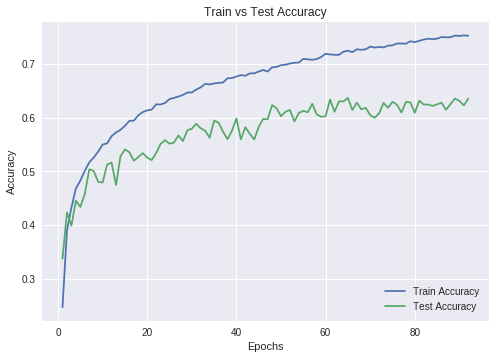

In [25]:
#CIFAR10 pretrained
train_accs = [acc.cpu().item() for acc in train_accs]
test_accs = [acc.cpu().item() for acc in test_accs]
# print(train_accs)
# print(test_accs)
plt.style.use('seaborn')
plt.plot(range(1, 93), train_accs, label='Train Accuracy')
plt.plot(range(1, 93), test_accs, label='Test Accuracy')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.title("Train vs Test Accuracy")
plt.legend(loc='lower right')

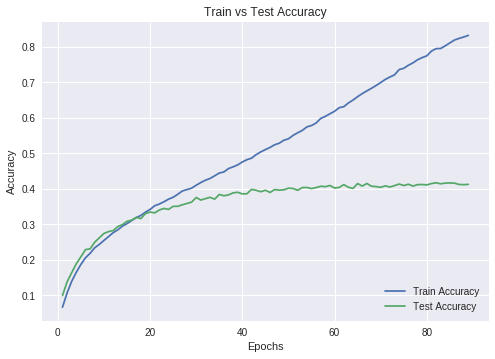

In [29]:
#CIFAR100
# train_accs = [acc.cpu().item() for acc in train_accs]
# test_accs = [acc.cpu().item() for acc in test_accs]
# print(train_accs)
# print(test_accs)
plt.style.use('seaborn')
plt.plot(range(1, 90), train_accs[:-1], label='Train Accuracy')
plt.plot(range(1, 90), test_accs, label='Test Accuracy')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.title("Train vs Test Accuracy")
plt.legend(loc='lower right')